<a href="https://colab.research.google.com/github/hiikariri/ecg-signal-processing/blob/main/final-project-dps-5023221004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from google.colab import drive

# Function Definition

In [ ]:
def detect_peaks(data, threshold):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > threshold and data[i] > data[i-1] and data[i] > data[i+1]:
            peaks.append(i)
    return peaks

def generate_pulse_qrs(data_length, peaks, width=10):
    pulse_qrs = np.zeros(data_length)
    for peak in peaks:
        start = max(0, peak - width // 2)
        end = min(data_length, peak + width // 2)
        pulse_qrs[start:end] = 1
    return pulse_qrs

def plot(x_axis, data, title, xlabel, ylabel, label='Series', subplot_position=221, color='blue', stem=False, half_freq=False):
    plt.subplot(subplot_position)
    if stem:
        plt.stem(x_axis, data, label=label, linefmt=color)
        plt.xlim(0, sampling_freq/2)
    else:
        plt.plot(x_axis, data, label=label, color=color)
        if half_freq:
            plt.xlim(0, sampling_freq/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

def low_pass_filter(cutoff_freq, indices, sampling_freq, data):
    ohm = 2 * np.pi * cutoff_freq / sampling_freq
    h = np.zeros(len(indices))
    y = np.zeros(len(data))

    for i in range(len(indices)):
        if indices[i] == 0:
            h[i] = ohm / np.pi
        else:
            h[i] = np.sin(ohm * indices[i]) / (np.pi * indices[i])

    for n in range(len(data)):
        for i in range(len(indices)):
            if n - i >= 0:
                y[n] += h[i] * data[n - i]
    return y

def band_pass_filter(low_cutoff_freq, high_cutoff_freq, indices, sampling_freq, data):
    low_cutoff_ohm = 2 * np.pi * low_cutoff_freq / sampling_freq
    high_cutoff_ohm = 2 * np.pi * high_cutoff_freq / sampling_freq
    h = np.zeros(len(indices))

    for i in range(len(indices)):
        if indices[i] == 0:
            h[i] = (high_cutoff_ohm - low_cutoff_ohm) / np.pi
        else:
            h[i] = (np.sin(high_cutoff_ohm * indices[i]) - np.sin(low_cutoff_ohm * indices[i])) / (np.pi * indices[i])

    y = np.convolve(data, h, mode='same')

    return y

def filter(data, sampling_freq, cutoff_freq=0, filter_order=1, low_cutoff_freq=0, high_cutoff_freq=0, filter_type="low_pass"):
    M = (filter_order - 1) // 2
    indices = np.arange(-M, M + 1, 1, dtype=int)

    if filter_type == "low_pass":
        filtered_signal = low_pass_filter(cutoff_freq, indices, sampling_freq, data)
    elif filter_type == "high_pass":
        raise NotImplementedError("High-pass filter is not implemented.")
    elif filter_type == "band_pass":
        filtered_signal = band_pass_filter(low_cutoff_freq, high_cutoff_freq, indices, sampling_freq, data)
    elif filter_type == "band_stop":
        raise NotImplementedError("Band-stop filter is not implemented.")
    else:
        raise ValueError("Invalid filter type")

    return filtered_signal

def spline_interpolate(x_source, y_source):
    spline = make_interp_spline(x_source, y_source, k=3)
    x_smooth = np.linspace(x_source.min(), x_source.max(), 300)
    y_smooth = spline(x_smooth)

    return x_smooth, y_smooth


def dft(total_data, data):
    x_real = np.zeros(total_data)
    x_im = np.zeros(total_data)
    dft_magnitude = np.zeros(total_data)

    for k in range(total_data):
        for n in range(total_data):
            x_real[k] += data[n] * np.cos(2 * np.pi * k * n / total_data)
            x_im[k] -= data[n] * np.sin(2 * np.pi * k * n / total_data)

    for k in range(total_data):
        dft_magnitude[k] = np.sqrt(x_real[k]**2 + x_im[k]**2)

    return dft_magnitude

def moving_average(data, orde_filter):
    y = np.zeros(len(data))
    for i in range(len(data)):
        for j in range(orde_filter):
            if i - j >= 0:
                y[i] += data[i - j]
        y[i] /= orde_filter
    return y

# Signal Input

Mounted at /content/drive
Enter the filter order: 3
Enter the path of the data: Data ECG Davis
Enter the sampling frequency: 125
Loading data...


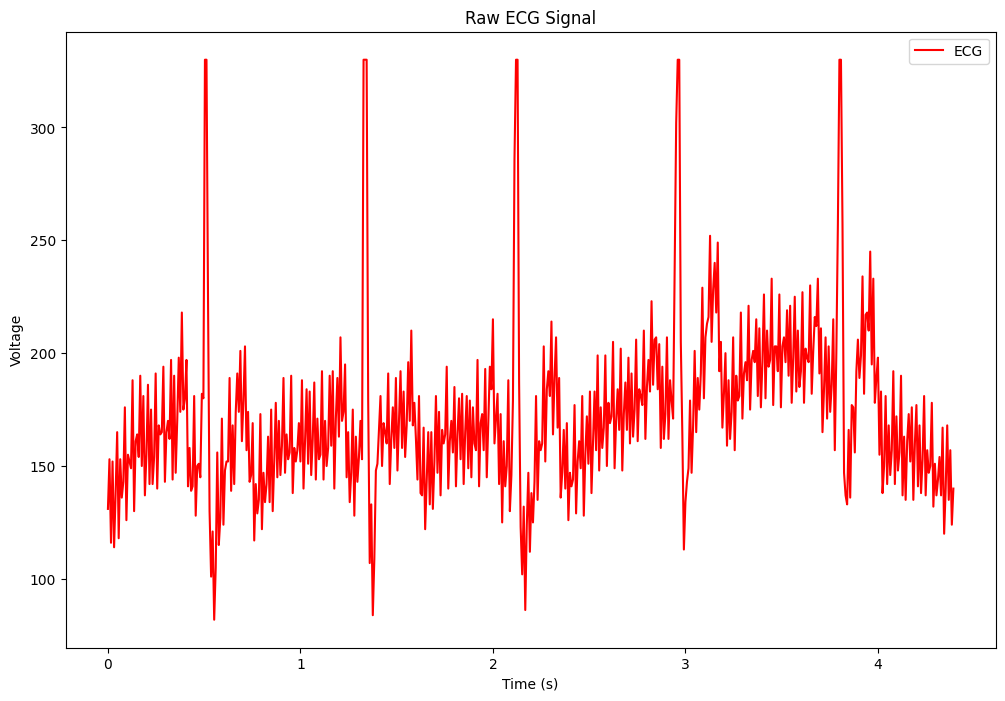

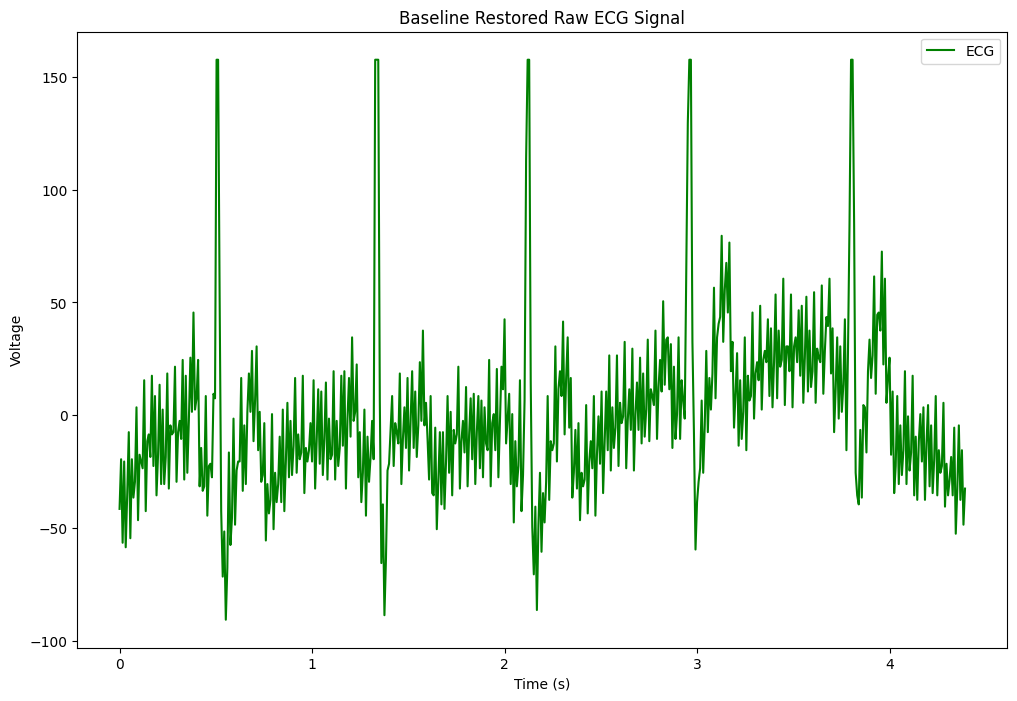

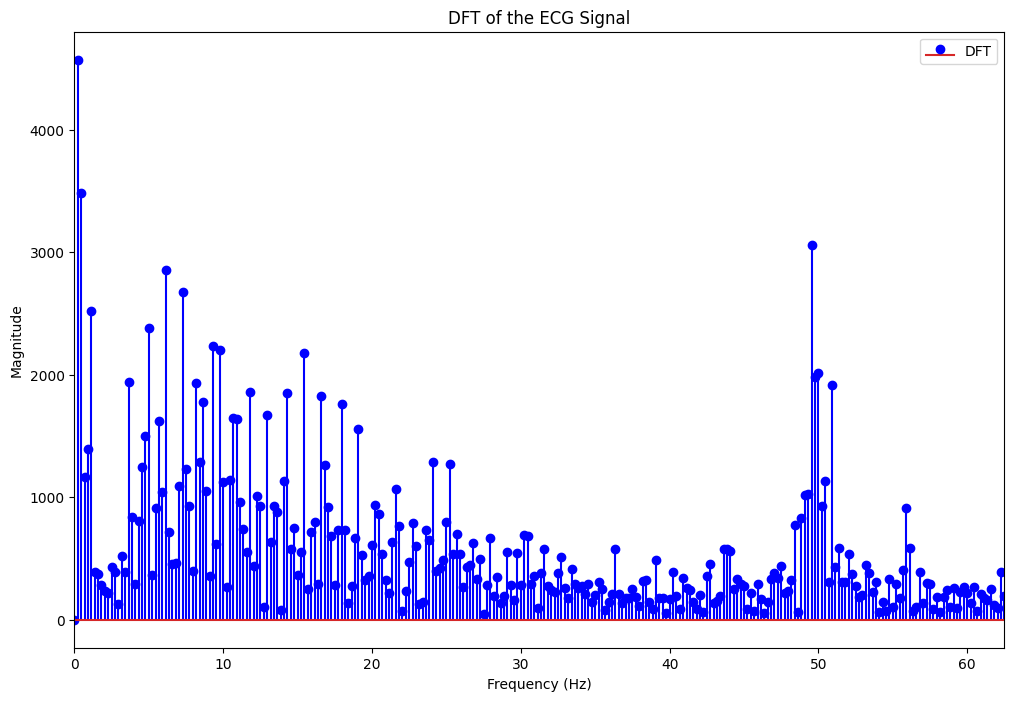

In [ ]:
drive.mount('/content/drive', force_remount = True)
orde = int(input("Enter the filter order: "))
path = input("Enter the path of the data: ")
sampling_freq = int(input("Enter the sampling frequency: "))
try:
    print("Loading data...")
    data_path = "/content/drive/MyDrive/" + path + ".txt"
    sequence, data = np.loadtxt(data_path, skiprows=1, delimiter=None, unpack=True)
except Exception as e:
    print(f"Error loading data: {e}")
    exit(1)

total_data = len(data)
sampling_time = total_data / sampling_freq
time_axis = np.arange(0, sampling_time, 1/sampling_freq)
freq_axis = np.arange(0, total_data) * sampling_freq / total_data

plt.figure(figsize=(12, 8))
plot(time_axis, data, 'Raw ECG Signal', 'Time (s)', 'Voltage', 'ECG', 111, color='red')

data = data - np.mean(data)
plt.figure(figsize=(12, 8))
plot(time_axis, data, 'Baseline Restored Raw ECG Signal', 'Time (s)', 'Voltage', 'ECG', 111, color='green')

dft_magnitude = dft(total_data, data)
plt.figure(figsize=(12, 8))
plot(freq_axis, dft_magnitude, 'DFT of the ECG Signal', 'Frequency (Hz)', 'Magnitude', 'DFT', 111, stem=True)

# Filter Processing

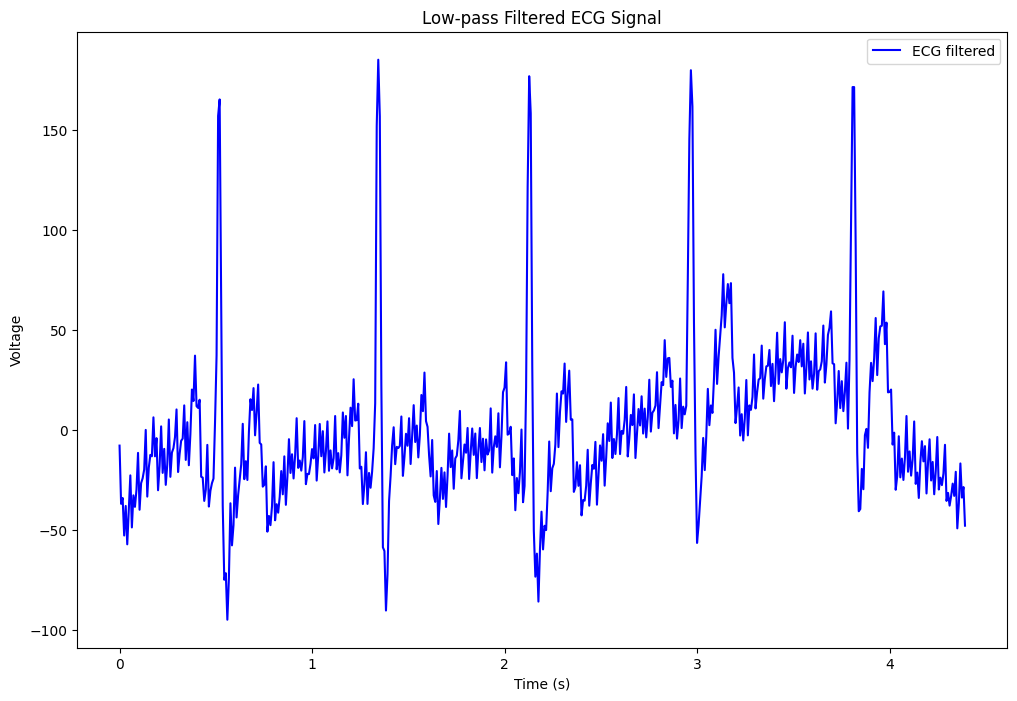

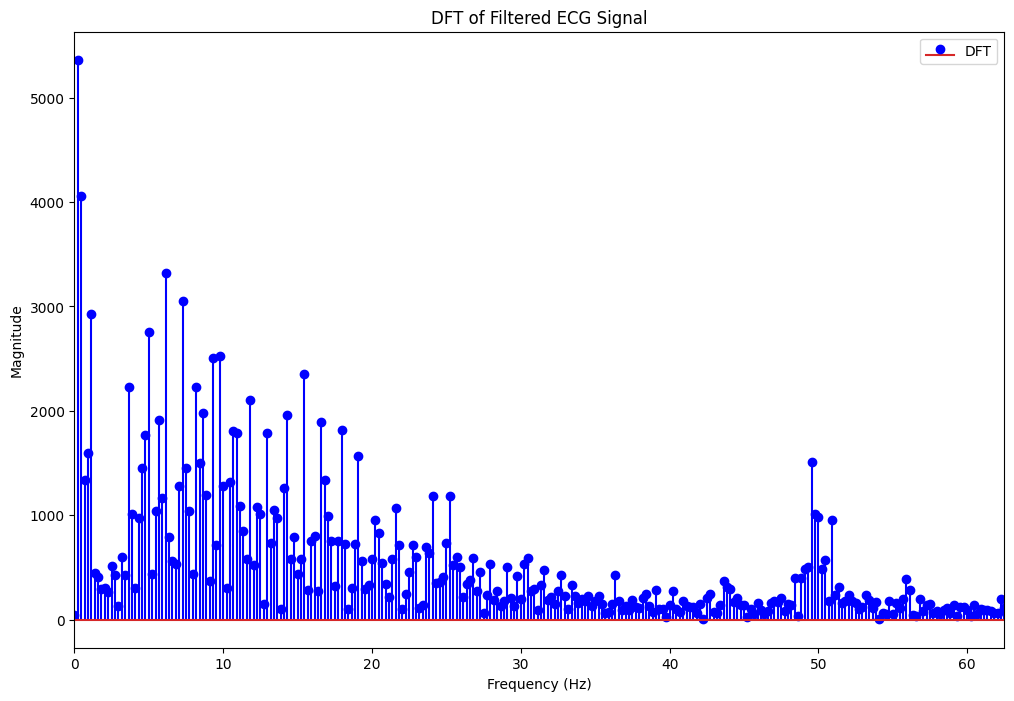

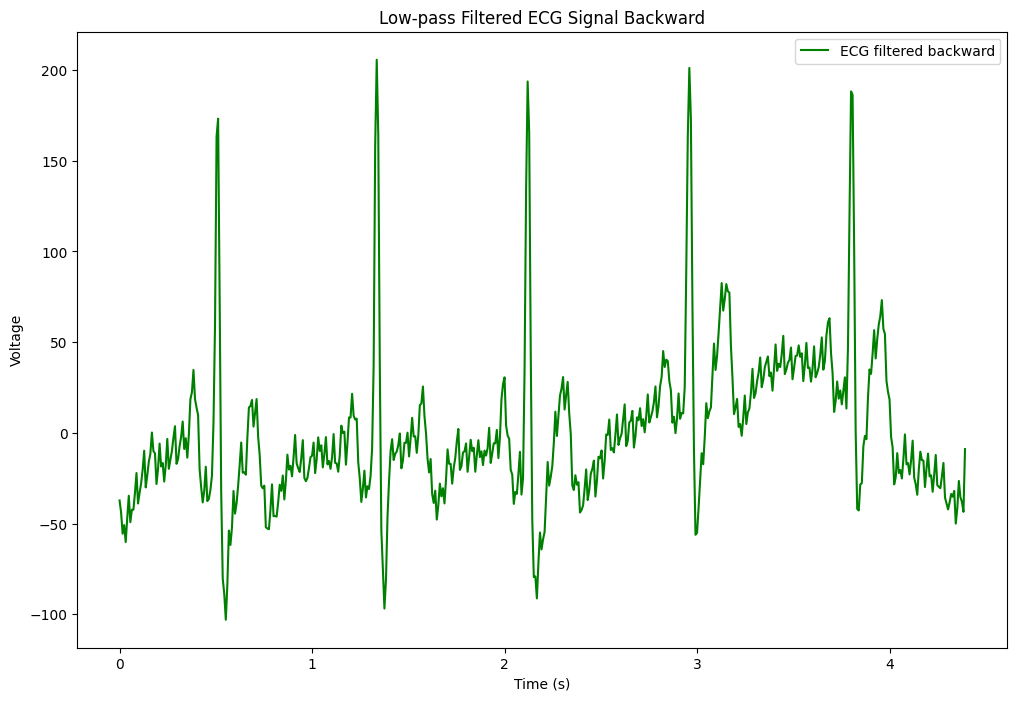

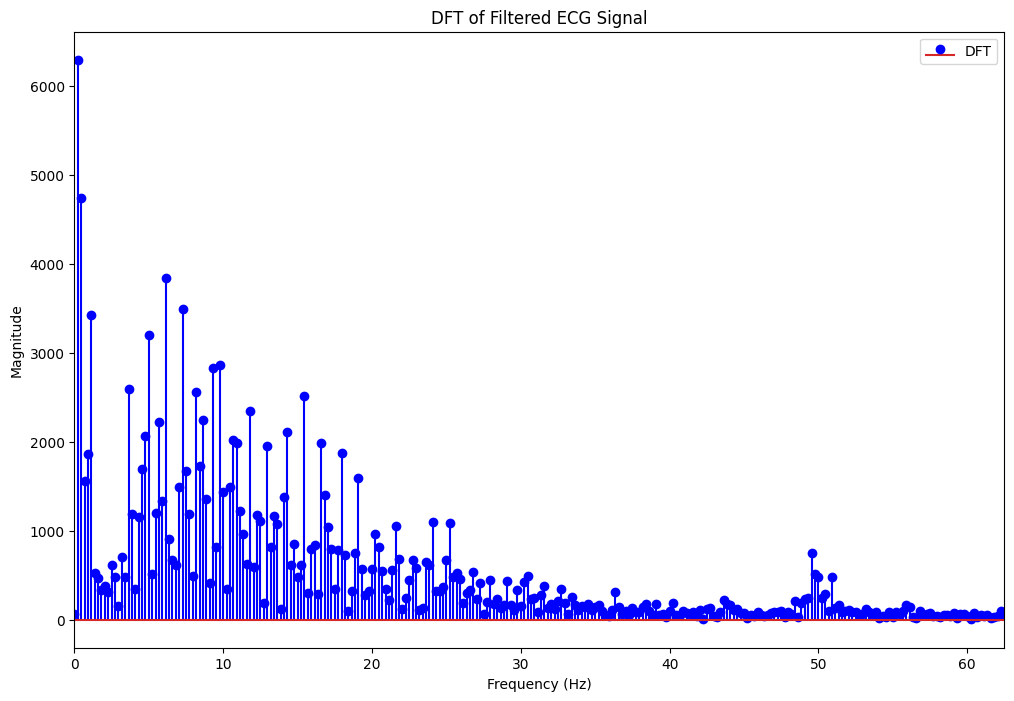

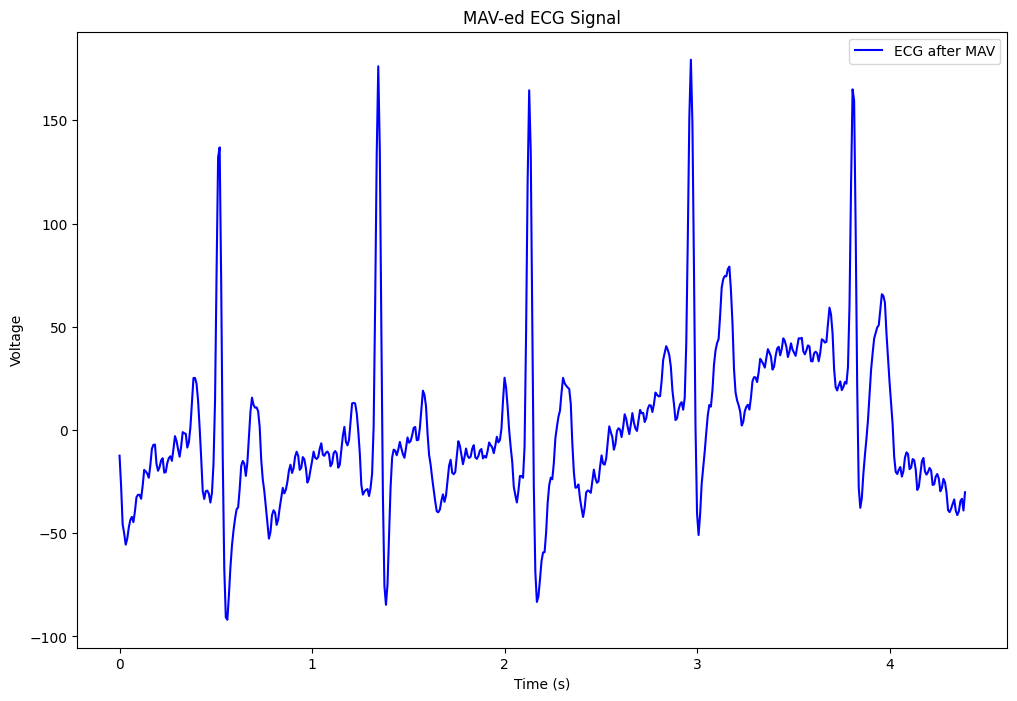

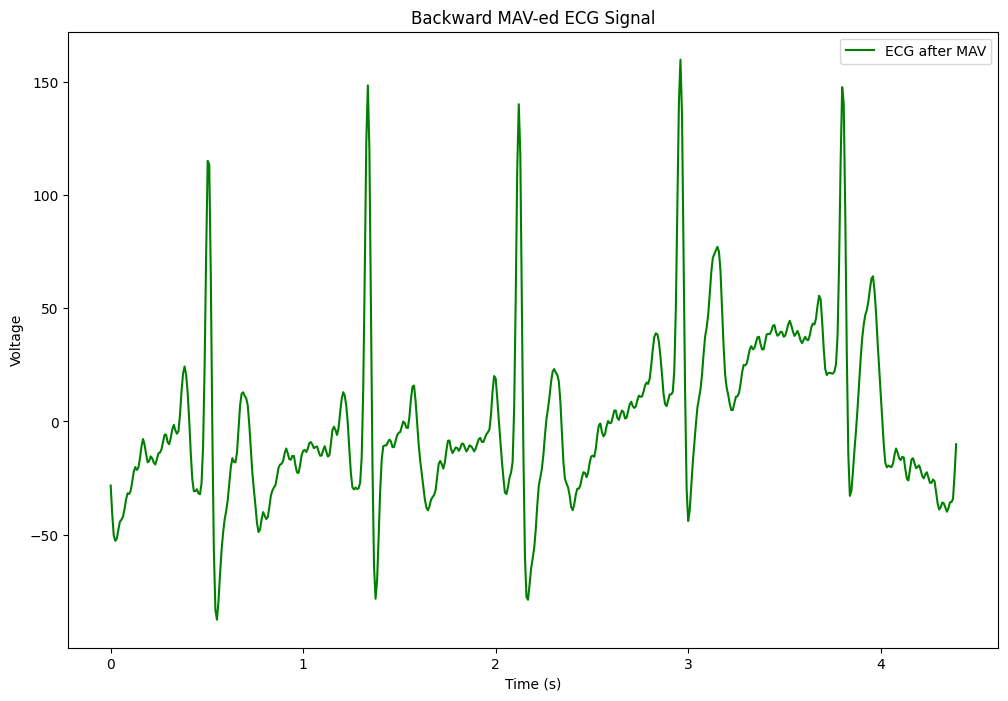

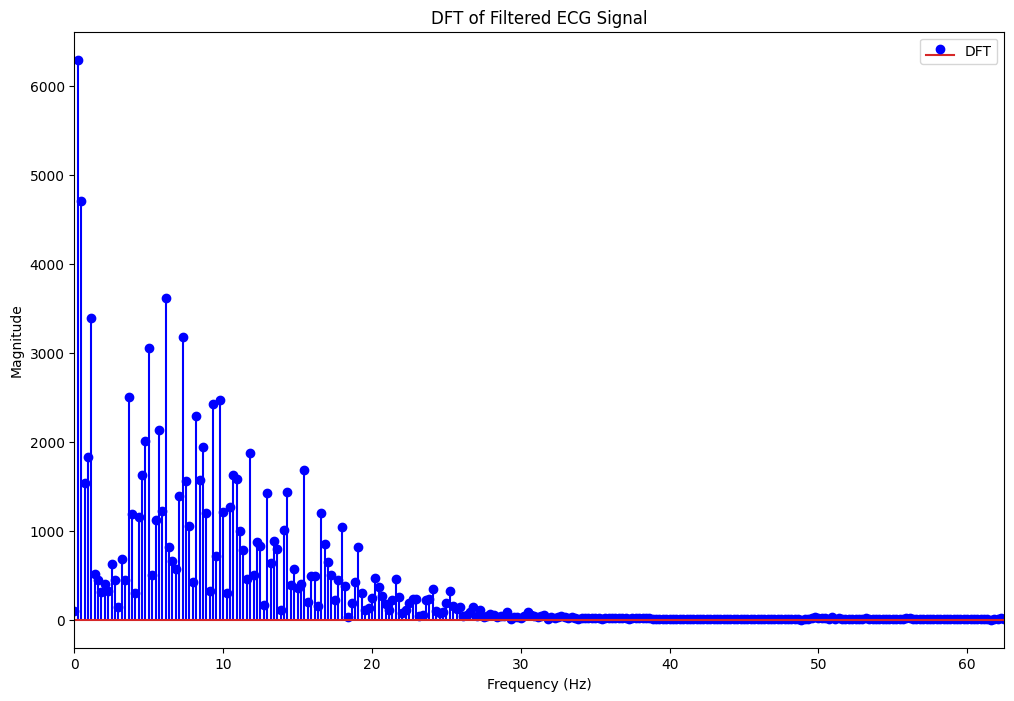

In [ ]:
data_filtered = filter(data=data, cutoff_freq=50, filter_order=orde, sampling_freq=125)
plt.figure(figsize=(12, 8))
plot(time_axis, data_filtered, 'Low-pass Filtered ECG Signal', 'Time (s)', 'Voltage', 'ECG filtered', 111, color='blue')

dft_magnitude_filtered = dft(total_data, data_filtered)
plt.figure(figsize=(12, 8))
plot(freq_axis, dft_magnitude_filtered, 'DFT of Filtered ECG Signal', 'Frequency (Hz)', 'Magnitude', 'DFT', 111, stem=True)

data_filtered = filter(data=data_filtered[::-1], cutoff_freq=50, filter_order=orde, sampling_freq=125)[::-1]
plt.figure(figsize=(12, 8))
plot(time_axis, data_filtered, 'Low-pass Filtered ECG Signal Backward', 'Time (s)', 'Voltage', 'ECG filtered backward', 111, color='green')

dft_magnitude_filtered = dft(total_data, data_filtered)
plt.figure(figsize=(12, 8))
plot(freq_axis, dft_magnitude_filtered, 'DFT of Filtered ECG Signal', 'Frequency (Hz)', 'Magnitude', 'DFT', 111, stem=True)

data_filtered = moving_average(data_filtered, orde)
plt.figure(figsize=(12, 8))
plot(time_axis, data_filtered, 'MAV-ed ECG Signal', 'Time (s)', 'Voltage', 'ECG after MAV', 111, color='blue')

data_filtered = moving_average(data_filtered[::-1], orde)[::-1]
plt.figure(figsize=(12, 8))
plot(time_axis, data_filtered, 'Backward MAV-ed ECG Signal', 'Time (s)', 'Voltage', 'ECG after MAV', 111, color='green')

dft_magnitude_filtered = dft(total_data, data_filtered)
plt.figure(figsize=(12, 8))
plot(freq_axis, dft_magnitude_filtered, 'DFT of Filtered ECG Signal', 'Frequency (Hz)', 'Magnitude', 'DFT', 111, stem=True)

# Segmentation

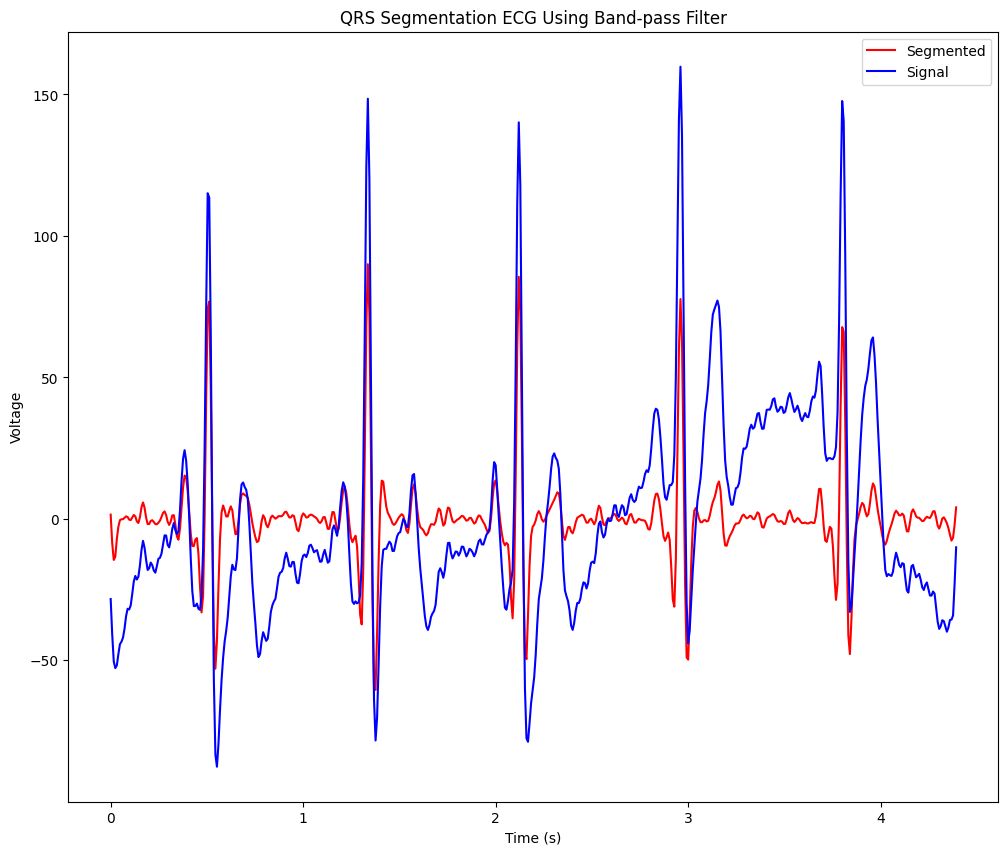

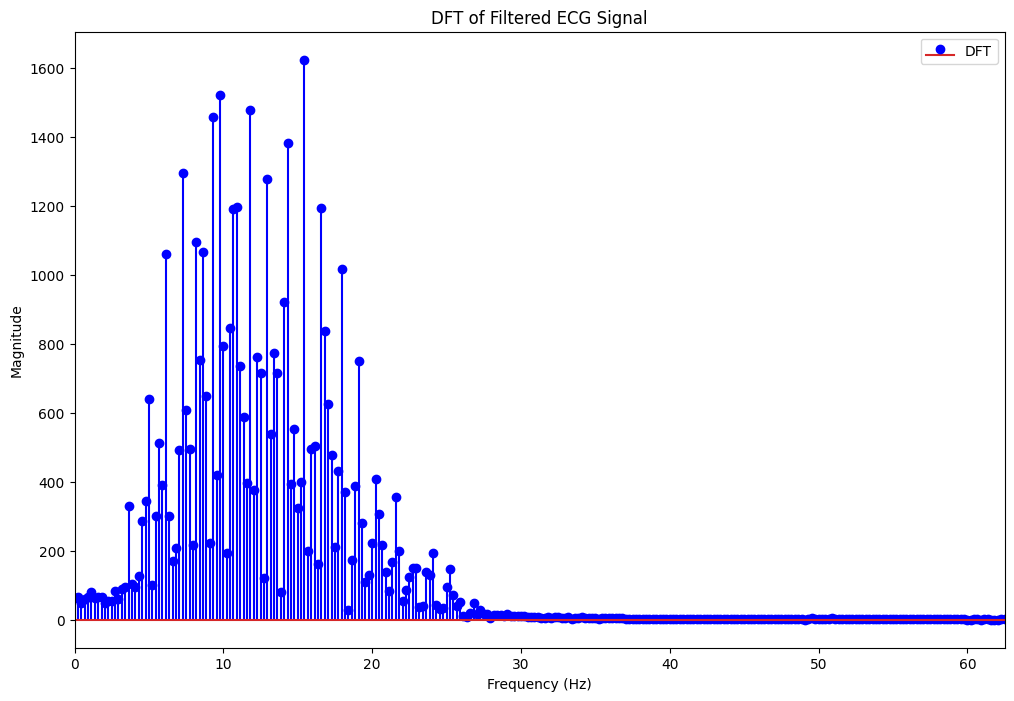

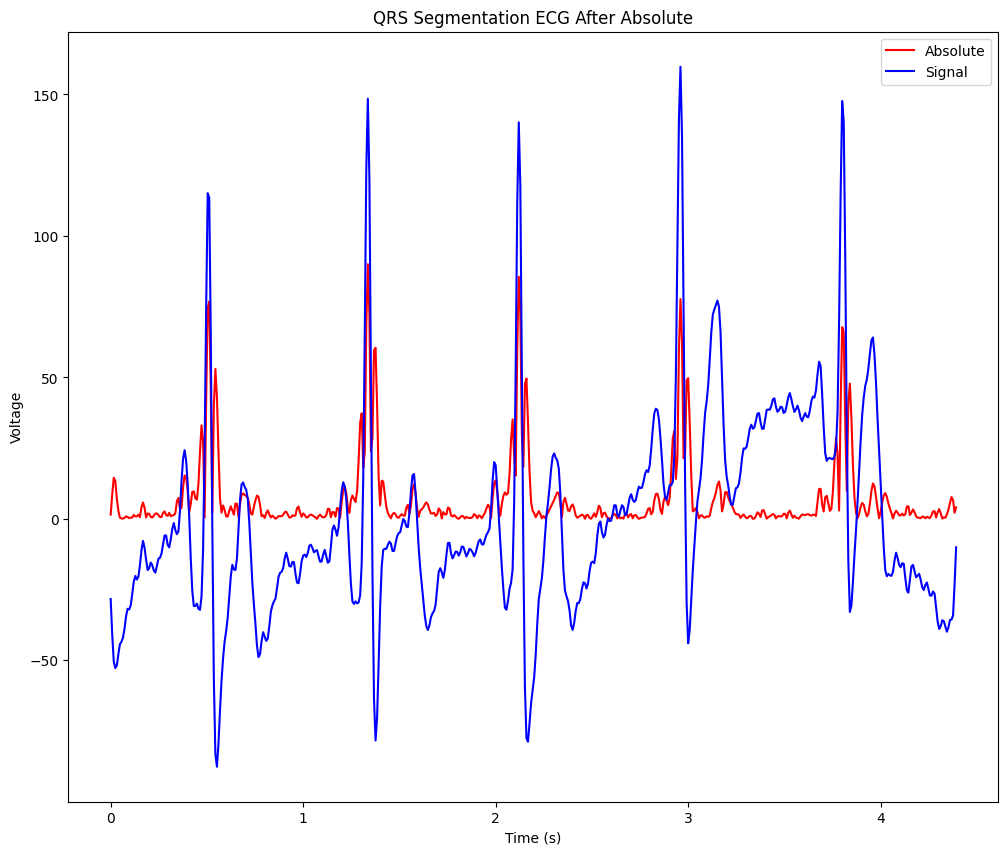

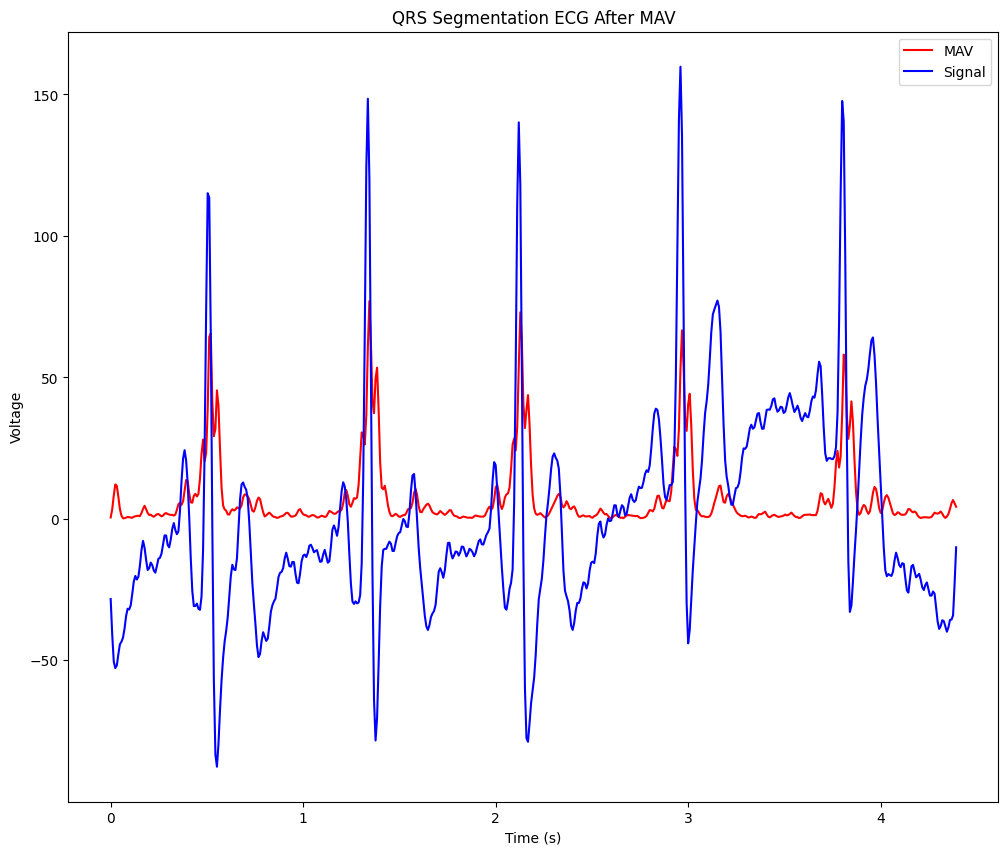

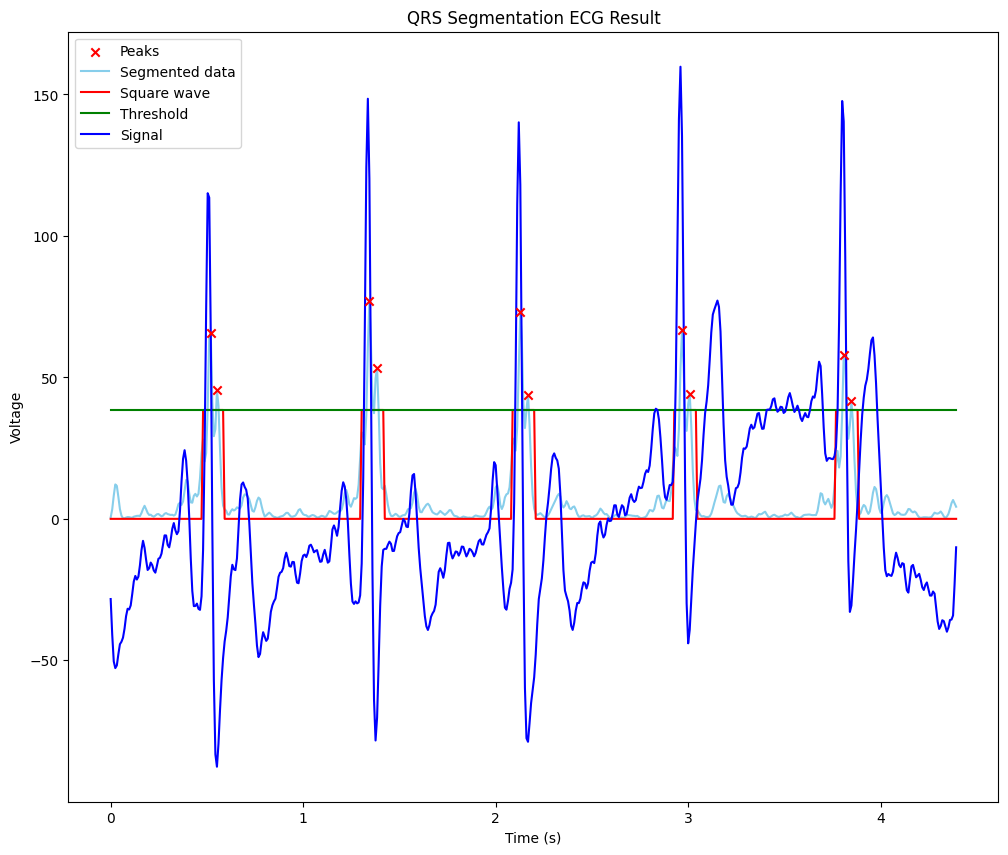

In [ ]:
segmented_data = filter(data=data_filtered, filter_order=9, sampling_freq=125, filter_type="band_pass", low_cutoff_freq=8, high_cutoff_freq=23)
segmented_data = filter(data=data_filtered[::-1], filter_order=9, sampling_freq=125, filter_type="band_pass", low_cutoff_freq=8, high_cutoff_freq=23)[::-1]
plt.figure(figsize=(12, 10))
plot(time_axis, segmented_data, 'QRS Segmentation ECG Using Band-pass Filter', 'Time (s)', 'Voltage', 'Segmented', 111, color='red')
plot(time_axis, data_filtered, 'QRS Segmentation ECG Using Band-pass Filter', 'Time (s)', 'Voltage', 'Signal', 111, color='blue')

dft_magnitude_segmented = dft(total_data, segmented_data)
plt.figure(figsize=(12, 8))
plot(freq_axis, dft_magnitude_segmented, 'DFT of Filtered ECG Signal', 'Frequency (Hz)', 'Magnitude', 'DFT', 111, stem=True)

segmented_data = abs(segmented_data)
plt.figure(figsize=(12, 10))
plot(time_axis, segmented_data, 'QRS Segmentation ECG After Absolute', 'Time (s)', 'Voltage', 'Absolute', 111, color='red')
plot(time_axis, data_filtered, 'QRS Segmentation ECG After Absolute', 'Time (s)', 'Voltage', 'Signal', 111, color='blue')

segmented_data = moving_average(segmented_data, 3)
plt.figure(figsize=(12, 10))
plot(time_axis, segmented_data, 'QRS Segmentation ECG After MAV', 'Time (s)', 'Voltage', 'MAV', 111, color='red')
plot(time_axis, data_filtered, 'QRS Segmentation ECG After MAV', 'Time (s)', 'Voltage', 'Signal', 111, color='blue')

threshold = 0.5 * np.max(segmented_data)  # Set a threshold for peak detection (more than half of amplitude)
peaks = detect_peaks(segmented_data, threshold) # Returns the indices when peak is happening
pulse_qrs = generate_pulse_qrs(len(segmented_data), peaks, width=10) # Generate a square wave with value of 1 and a certain width
pulse_qrs = pulse_qrs * threshold # Make the value of square wave to the same as threshold (for plot purposes)

threshold_axis = [threshold] * total_data # Make an axis of threshold just to plot the threshold line
peak_times = time_axis[peaks]
peak_values = segmented_data[peaks] # X mark the peak of segmented data
plt.figure(figsize=(12, 10))
plt.scatter(peak_times, peak_values, color='red', zorder=5, label='Peaks', marker='x')
plot(time_axis, segmented_data, 'QRS Segmentation ECG Result', 'Time (s)', 'Voltage', 'Segmented data', 111, color='skyblue')
plot(time_axis, pulse_qrs, 'QRS Segmentation ECG Result', 'Time (s)', 'Voltage', 'Square wave', 111, color='red')
plot(time_axis, threshold_axis, 'QRS Segmentation ECG Result', 'Time (s)', 'Voltage', 'Threshold', 111, color='green')
plot(time_axis, data_filtered, 'QRS Segmentation ECG Result', 'Time (s)', 'Voltage', 'Signal', 111, color='blue')

# Signal Analysis Result

In [ ]:
times_of_rising_edges = []
for i in range(len(pulse_qrs)):
  if pulse_qrs[i] > pulse_qrs[i - 1]:
      times_of_rising_edges.append(time_axis[i])

filtered_times_of_rising_edges = [times_of_rising_edges[0]]
for i in range(len(times_of_rising_edges)):
  if (times_of_rising_edges[i] - filtered_times_of_rising_edges[-1]) >= 0.5:
      filtered_times_of_rising_edges.append(times_of_rising_edges[i])

rr_interval = []
for i in range(len(filtered_times_of_rising_edges)):
  if (i == len(filtered_times_of_rising_edges) - 1): break
  rr_interval.append(filtered_times_of_rising_edges[i+1] - filtered_times_of_rising_edges[i])

print(filtered_times_of_rising_edges)
print(rr_interval)
rr_mean = np.mean(rr_interval)
heart_rate = 60.0 / rr_mean
print("Subject Heart Rate is " + str(heart_rate) + " BPM")

[0.48, 1.304, 2.088, 2.928, 3.7680000000000002]
[0.8240000000000001, 0.784, 0.8399999999999999, 0.8400000000000003]
Subject Heart Rate is 72.992700729927 BPM
